In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Lasso
from cvxopt.solvers import qp
from cvxopt import solvers
from cvxopt.blas import dot
from cvxopt import matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture  import GaussianMixture
from sklearn.metrics import confusion_matrix

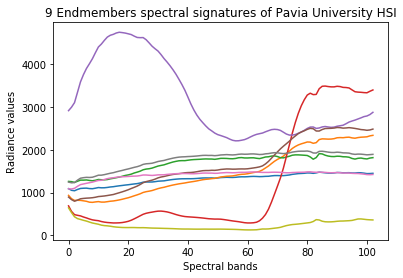

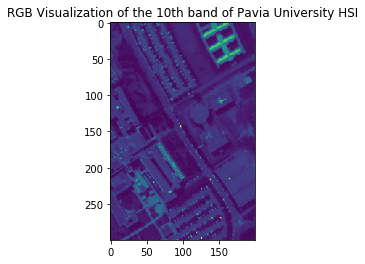

In [2]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

# Part 1

In [3]:
M = HSI.shape[0]
N = HSI.shape[1]
m = endmembers.shape[1]
Least_squares = np.zeros((m,M,N))
reg = LinearRegression(fit_intercept=False)
error = 0
for i in range(M):
    for j in range(N):
        if labels[i][j] != 0:
            Least_squares[:,i,j] = reg.fit(endmembers,HSI[i][j].reshape(-1,1)).coef_
            error += pow(np.sum(HSI[i][j] - np.dot(endmembers,Least_squares[:,i,j])),2)/103
ls_error = error/np.count_nonzero(labels)
print('The error for Least Squares is :',ls_error)

The error for Least Squares is : 0.582448731872167


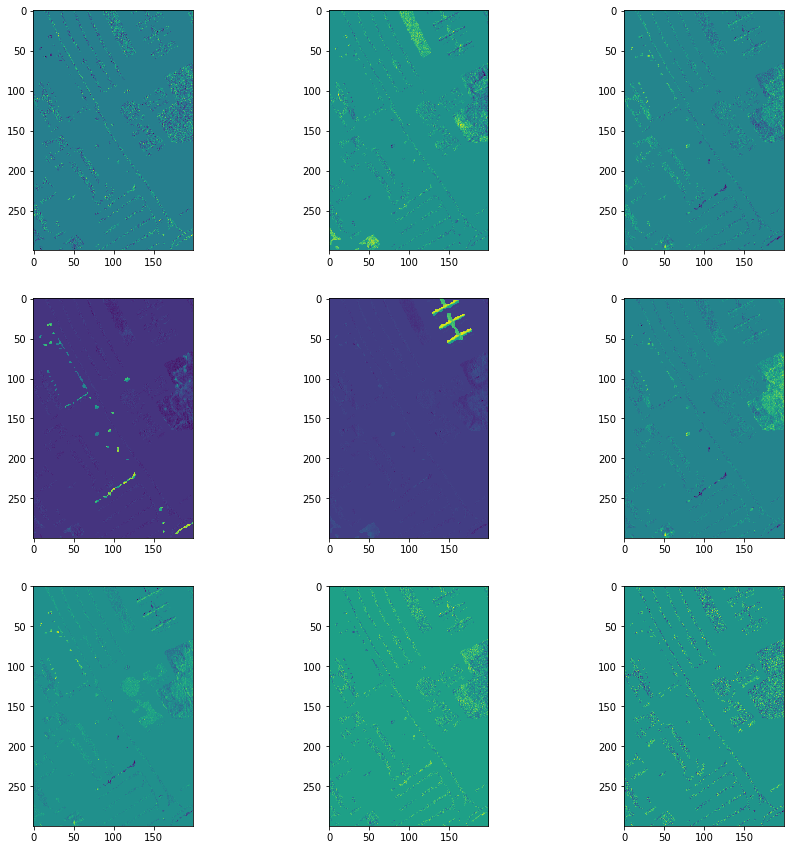

In [305]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    fig.add_subplot(3, 3, j+1)
    plt.imshow(Least_squares[j])
plt.show()

### Source i used
* https://scaron.info/blog/quadratic-programming-in-python.html

In [4]:
P = matrix(np.dot(endmembers.T,endmembers))
G = matrix(np.zeros((1,9)))
h = matrix(np.zeros(1))
A = matrix(np.ones((1,9)))
b = matrix(np.ones(1))
ls_sum_to_one = np.zeros((m,M,N))
result = []
error = 0
solvers.options['show_progress'] = False
for i in range(M):
    for j in range(N):
        if labels[i][j] != 0:
            q = matrix(-np.dot(endmembers.T, HSI[i][j]))
            sol = qp(P,q,G,h,A,b)
            if 'optimal' not in sol['status']:
                ls_sum_to_one[:,i,j] = None
            ls_sum_to_one[:,i,j] = np.array(sol['x']).reshape((m,))
            error += pow(np.sum(HSI[i][j] - np.dot(endmembers,ls_sum_to_one[:,i,j])),2)/103
error_sum_to_one = error/np.count_nonzero(labels)
print('The error for Least Squares with constraints that sum to one is :',error_sum_to_one)

The error for Least Squares with constraints that sum to one is : 62.68512364676036


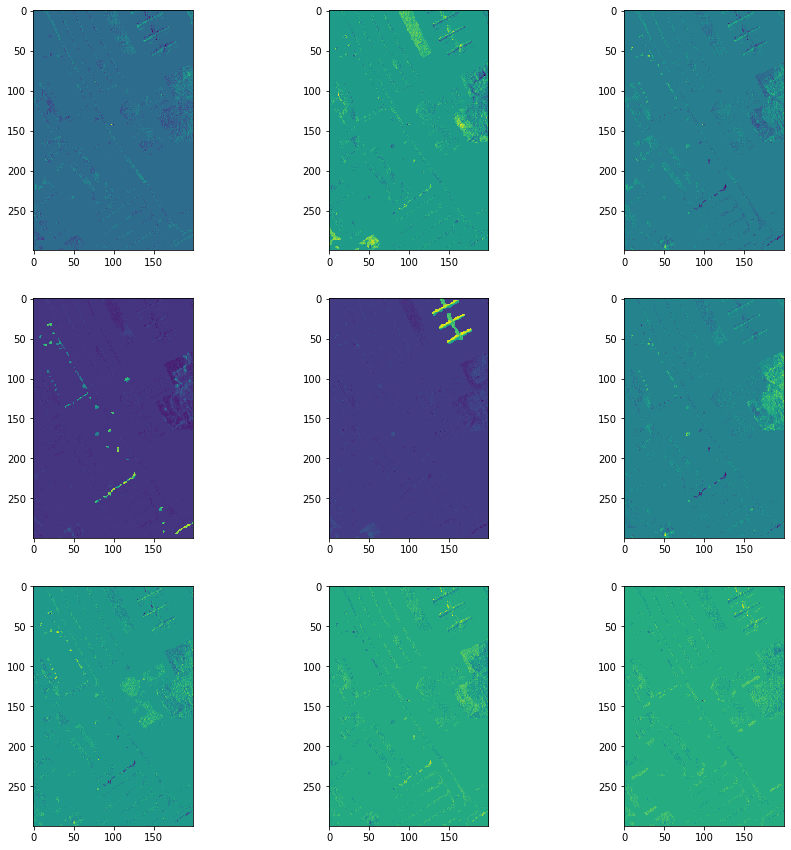

In [307]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    fig.add_subplot(3, 3, j+1)
    plt.imshow(ls_sum_to_one[j])
plt.show()

In [5]:
G = matrix(-np.eye(9))
h = matrix(np.zeros((9,1)))
ls_non_negative = np.zeros((m,M,N))
error = 0
solvers.options['show_progress'] = False
for i in range(M):
    for j in range(N):
        if labels[i][j] != 0:
            q = matrix(-np.dot(endmembers.T, HSI[i][j]))
            sol = qp(P,q,G,h)
            if 'optimal' not in sol['status']:
                ls_non_negative[:,i,j] = None
            ls_non_negative[:,i,j] = np.array(sol['x']).reshape((m,))
            error += pow(np.sum(HSI[i][j] - np.dot(endmembers,ls_non_negative[:,i,j])),2)/103
error_non_negative = error/np.count_nonzero(labels)
print('The error for Least Squares with non negative constraints  is :',error_non_negative)

The error for Least Squares with non negative constraints  is : 13962.635784634855


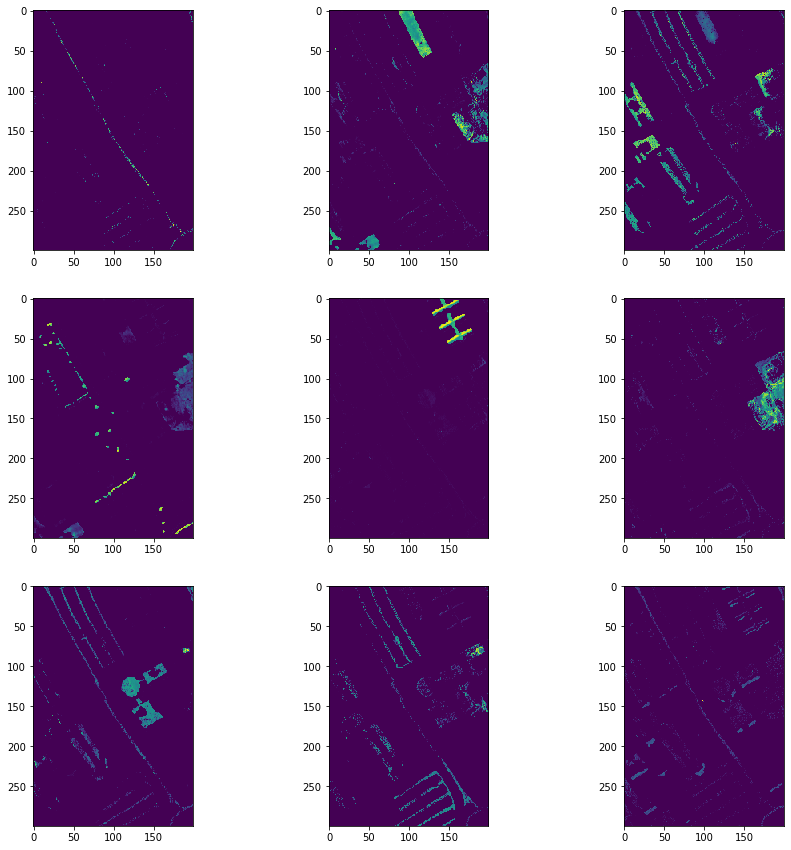

In [309]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    fig.add_subplot(3, 3, j+1)
    plt.imshow(ls_non_negative[j])
plt.show()

In [6]:
G = matrix(-np.eye(9))
h = matrix(np.zeros((9,1)))
A = matrix(np.ones((1,9)))
b = matrix(np.ones(1))
ls_non_sum = np.zeros((m,M,N))
error = 0
solvers.options['show_progress'] = False
for i in range(M):
    for j in range(N):
        if labels[i][j] != 0:
            q = matrix(-np.dot(endmembers.T, HSI[i][j]))
            sol = qp(P,q,G,h,A,b)
            if 'optimal' not in sol['status']:
                ls_non_sum[:,i,j] = None
            ls_non_sum[:,i,j] = np.array(sol['x']).reshape((m,))
            error += pow(np.sum(HSI[i][j] - np.dot(endmembers,ls_non_sum[:,i,j])),2)/103
error_non_sum = error/np.count_nonzero(labels)
print('The error for Least Squares with non negative constraints that sum to one is :',error_non_sum)

The error for Least Squares with non negative constraints that sum to one is : 2556143.7400588235


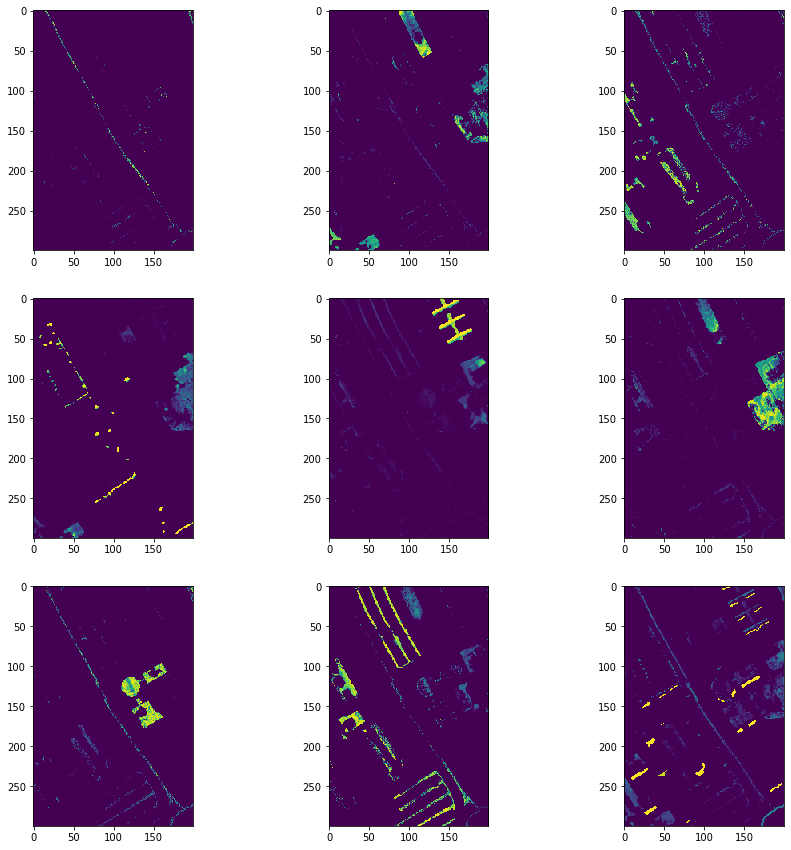

In [311]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    fig.add_subplot(3, 3, j+1)
    plt.imshow(ls_non_sum[j])
plt.show()

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [8]:
clf = Lasso(alpha=1.0,fit_intercept=False,warm_start=True)
error = 0
lasso =np.zeros((m,M,N))
for i in range(M):
    for j in range(N):
        if labels[i][j] != 0:
            lasso[:,i,j] = clf.fit(endmembers,HSI[i][j].reshape(-1,1)).coef_
            error += pow(np.sum(HSI[i][j] - np.dot(endmembers,Least_squares[:,i,j])),2)/103
lasso_error = error/np.count_nonzero(labels)
print('The error for Lasso is :',lasso_error)

The error for Lasso is : 0.582448731872167


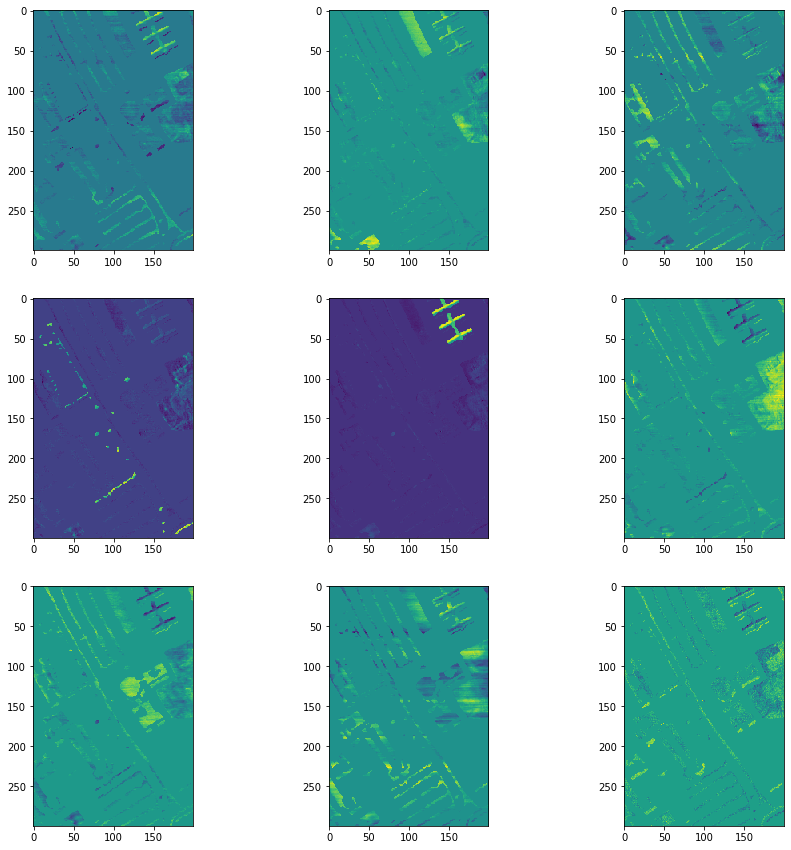

In [313]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    fig.add_subplot(3, 3, j+1)
    plt.imshow(lasso[j])
plt.show()

In [93]:
def summ(estimator):
     return [np.sum((labels.ravel()-estimator[i].ravel())**2)/(len(labels)*len(labels[0])) for i in range(9)]
models = {}
models["least squares"] = Least_squares
models["Sum to one constraint"] = ls_sum_to_one
models["Non negative constraint"] = ls_non_negative
models["Non negative and sum to one constraint"] = ls_non_sum
models["Lasso"] = lasso

In [106]:
for name in models:
    model = models[name]
    result = summ(model)
    print(name,"\n",np.round(result,3),round(np.mean(result),3))

least squares 
 [9.339 6.761 7.143 6.677 6.642 6.287 6.739 9.184 6.991] 7.307
Sum to one constraint 
 [7.845 6.749 7.178 6.677 6.642 6.283 6.682 8.673 6.64 ] 7.041
Non negative constraint 
 [6.732 6.535 6.377 6.58  6.629 6.5   6.38  6.394 6.483] 6.512
Non negative and sum to one constraint 
 [6.728 6.59  6.573 6.588 6.577 6.417 6.488 6.297 6.419] 6.52
Lasso 
 [6.636 6.662 6.418 6.67  6.639 6.248 6.538 6.567 6.726] 6.567


* Comparing the Abundance maps with the labels matrix (the original map) over the five models we conclude that Least squares with non negative and sum to one constraint , Least squares with non negative and lasso performed best overall and least squares and least squares with sum to one constrain follow closely.If we compare the perfomance not overall but in every layer and see which one is closer to the truth we observe that Least squares with non negative and sum to one constraint , Least squares with non negative and lasso have similar performance while least squares and least squares with sum to one constraint had worse perfomance in 1st,3rd and 8th layer.
* If we compare the reconstruction error then the results are not the same. Lasso and Least squares perfomed best while the rest models have significantly larger error the more constraints we add. In numbers lasso and Least squares scored both 0.58 reconstruction error , least squares with sum to one constraint scored 62.68, least squares with non negative constraint scored 130962,63 and finaly least squares with sum to one and non negative constraint scored 2556143.74
* To conculde adding more constraints results deviation from the captured image and the portion of pure pixel (endmembers) which is intuitive due to the difficulty of solving a quadratic programming with extra constraints,however adding more constraints or choossing a sparse solution like lasso led to a better result in terms of convergence to the real truth which is again logical because in reality and therefore in the ground truth matrix the matirials are unique and one every time, so choosing a sparse theta or a theta with constraints leads to a more realistic result .

# Part 2

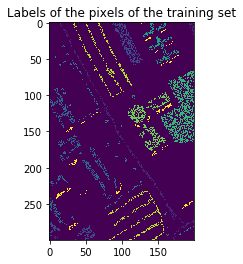

In [3]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [4]:
M = HSI.shape[0]
N = HSI.shape[1]
x = []
y = []
for i in range(M):
    for j in range(N):
        if Training_Set[i,j] != 0:
            x.append(HSI[i,j])
            y.append(Training_Set[i,j])
            
x_test = []
y_test = []
for i in range(M):
    for j in range(N):
        if Test_Set[i,j] != 0:
            x_test.append(HSI[i,j])
            y_test.append(Test_Set[i,j])

In [6]:
folds = 10
seed = 10
naive = GaussianNB()
k_fold  = KFold(n_splits=folds, random_state=seed)
results = cross_val_score(naive,x, y, cv=k_fold)
print("{}: {}, {}".format("Naive bayes",round(results.mean(), 3),round(results.std(), 3)))

naive = GaussianNB()
naive.fit(x,y)
pred_naive = naive.predict(np.array(x_test))
conf = confusion_matrix(y_test,pred_naive)
print("Confusion Matrix \n",conf)

i=range(9)
success_rate = conf[i,i].sum()/conf.sum()
print("Naive bayes success rate:",success_rate)
print("Misclassified data \n", np.sum(conf,axis=1)-conf[i,i])

Naive bayes: 0.591, 0.158
Confusion Matrix 
 [[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]]
Naive bayes success rate: 0.660118490801372
Misclassified data 
 [130  27 409   2   2 401  44  73   2]


In Naive bayes classification the 1st,3rd and 6th class are not well seprated 

In [276]:
knn = KNeighborsClassifier(n_neighbors=10)
k_fold  = KFold(n_splits=folds, random_state=seed)
results_knn = cross_val_score(knn, x, y, cv=k_fold)
print("{}: {}, {}".format("KNN", round(results_knn.mean(), 3), round(results_knn.std(), 3)))

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x,y)
pred_knn = knn.predict(np.array(x_test))
conf = confusion_matrix(y_test,pred_knn)
print("Confusion Matrix \n",conf)

i = range(9)
success_rate = conf[i,i].sum()/conf.sum()
print("KNN success rate:",success_rate)
print("Misclassified data \n", np.sum(conf,axis=1)-conf[i,i])

KNN: 0.76, 0.151
Confusion Matrix
[[189   0  11   0   0   0  28  33   0]
 [  0 330   0   1   0  21   0   1   0]
 [ 11   2 457   0   0   5   1  60   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  75   1   0   1 686   0   1   0]
 [ 14   0   5   0   0   0 300   2   0]
 [  7   2  93   0   0   0   1 358   0]
 [  0   0   0   0   0   0   0   0 187]]
KNN success rate: 0.8818210165263486
Misclassified data 
 [ 72  23  79   1   2  78  21 103   0]


In KNN classification the 8th class is not well seprated 

In [49]:
p = []
ind = []
# compute the probabilities of every class
for i in range(10):
#     take the index of each class
    ind.append(np.where(np.stack(y)==i)[0])
    p.append(len(ind[i])/len(y))
mean = []
del p[0]

eucl_err = []
for train_indx,test_indx in k_fold.split(x):
    index = []
    for i in range(10):
#     take the index of each class
        index.append(np.where(np.stack(y)[train_indx]==i)[0])
    del index[0]
    mean = []
    for i in index:
        sum = 0
        for j in i:
            sum += x[j]
        mean.append(sum/len(i))
    mean = np.min(mean,axis=1)
    diff = []    
    for j in range(9):    
        diff.append(np.stack([x[i]- ([mean[j]]*103) for i in test_indx]))
    diff = np.reshape(diff,(len(test_indx),103,9))
    eucl = []
    for j in range(len(test_indx)):
        tmp = []
        for i in range(9):
            tmp.append(np.dot(diff[j,i].T,diff[j,i])+np.log(p[i]))
        eucl.append(np.where(tmp==max(tmp))[0]+1)
    eucl_err.append(np.count_nonzero(eucl[0][0]==y)/len(y))
print("{}: {}, {}".format("Euclidean distance", round(np.array(eucl_err).mean(), 3), round(np.array(eucl_err).std(), 3)))

Euclidean distance: 0.105, 0.067


In [59]:
p = []
ind = []
for i in range(10):
#     take the index of each class
    ind.append(np.where(np.stack(y)==i)[0])
    p.append(len(ind[i])/len(y))
mean = []
del p[0]

eucl_err = []
index = []
for i in range(10):
#     take the index of each class
    index.append(np.where(np.stack(y)==i)[0])
del index[0]
mean = []
for i in index:
    sum = 0
    for j in i:
        sum += x[j]
    mean.append(sum/len(i))
mean = np.min(mean,axis=1)
diff = []    
for j in range(9):    
    diff.append(np.stack([x_test[i]-([mean[j]]*103) for i in range(len(x_test))]))
diff = np.reshape(diff,(len(x_test),103,9))
eucl = []
for j in range(len(x_test)):
    tmp = []
    for i in range(9):
        tmp.append(np.dot(diff[j,i].T,diff[j,i])+np.log(p[i]))
    eucl.append(np.where(tmp==max(tmp))[0]+1)

conf = confusion_matrix(y_test,eucl)
print("Confusion Matrix \n",conf)

i = range(9)
success_rate = conf[i,i].sum()/conf.sum()
print("Euclidian distance success rate:",success_rate)
print("Misclassified data \n", np.sum(conf,axis=1)-conf[i,i])

Confusion Matrix 
 [[ 15   4  12   0   2   3  21  13 191]
 [ 19   5  10   1   8   4  17  22 267]
 [ 30  14  23   1   8   9  23  33 395]
 [  8   2   3   0   4   2   8  10 119]
 [ 11   2   6   0   2   4  10  14 119]
 [ 38  10  39   0  21   4  32  45 575]
 [ 22   5  12   1   3   4  16  18 240]
 [ 27  11  18   1  11   8  17  29 339]
 [ 16   1   3   2   4   1   9   8 143]]
Euclidian distance success rate: 0.07390084190832553
Misclassified data 
 [246 348 513 156 166 760 305 432  44]


In euclidian distance classifier all the classes are bad separated as we can see from the success rate as well

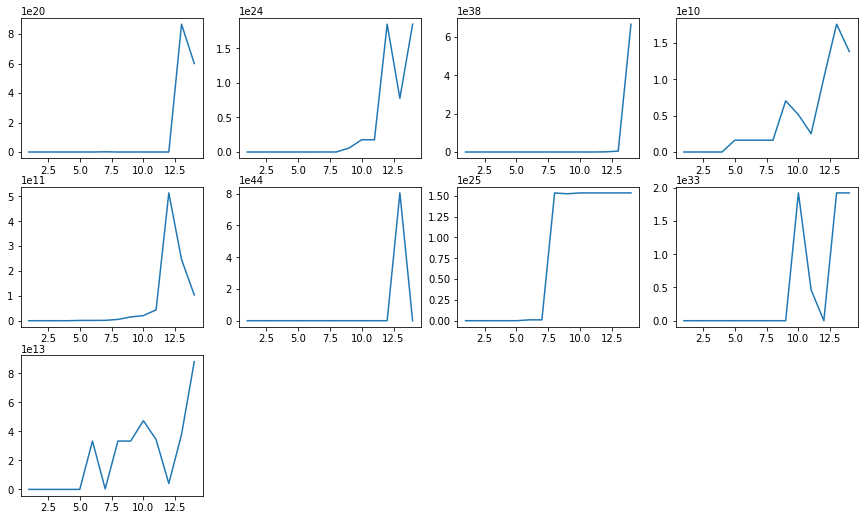

In [111]:
fig=plt.figure(figsize=(15,15))
for j in range(0,9):
    score = []
    for i in range(1,15):
        class1 = GaussianMixture(n_components=i)
        class1.fit(np.stack(x)[index[j]])
        score.append(np.exp((class1.score_samples(np.stack(x)[index[j]]))*p[j]).mean())
    fig.add_subplot(5, 4, j+1)
    plt.plot(range(1,15),score)
plt.show()

In [258]:
comp = [13,11,14,13,12,13,12,10,14]
k_fold  = KFold(n_splits=folds, random_state=seed)
clas_err = []
ind = []
p = []
# compute the probabilities in every class
for i in range(10):
#     take the index of each class
    ind.append(np.where(np.stack(y)==i)[0])
    p.append(len(ind[i])/len(y)) 
del p[0]

# split in 10 set for cross validation
for train_indx,test_indx in k_fold.split(x):
    index = []
#   compute the index of every class 
    for i in range(10):
#     take the index of each class
        index.append(np.where(np.stack(y)[train_indx]==i)[0])
    del index[0]
    
    score = []
    for i in range(9):
        class_ = GaussianMixture(n_components=comp[i])
        class_.fit(np.stack(x)[index[i]])
        score.append(np.exp((class_.score_samples(np.stack(x)[test_indx])))*p[i])
    Btest_y = np.empty((0,1),int)
    for i in np.stack(score,axis=1):
        Btest_y = np.concatenate((Btest_y,[[np.where(i == np.amax(i))[0][0] + 1]]),axis=0)
    clas_err.append(np.count_nonzero(Btest_y==np.stack(y)[test_indx])/(len(Btest_y)**2))

print("{}: {}, {}".format("Bayes", round(np.array(clas_err).mean(), 3), round(np.array(clas_err).std(), 3)))

Bayes: 0.2, 0.095


In [281]:
clas_err = []
ind = []
p = []
# compute the probabilities in every class
for i in range(10):
#     take the index of each class
    ind.append(np.where(np.stack(y)==i)[0])
    p.append(len(ind[i])/len(y)) 
del p[0]


index = []
#   compute the index of every class 
for i in range(10):
#     take the index of each class
    index.append(np.where(np.stack(y)==i)[0])
del index[0]

score = []
for i in range(9):
    class_ = GaussianMixture(n_components=comp[i])
    class_.fit(np.stack(x)[index[i]])
    score.append(np.exp((class_.score_samples(np.stack(x_test))))*p[i])
Btest_y = np.empty((0,1),int)
for i in np.stack(score,axis=1):
    Btest_y = np.concatenate((Btest_y,[[np.where(i == np.amax(i))[0][0] + 1]]),axis=0)
    
conf = confusion_matrix(y_test,Btest_y)
print("Confusion Matrix \n",conf)

i = range(9)
success_rate = conf[i,i].sum()/conf.sum()
print("Bayes success rate:",success_rate)
print("Misclassified data \n", np.sum(conf,axis=1)-conf[i,i])

Confusion Matrix 
 [[  0   0 104   0   0 142  13   2   0]
 [  0  28   0   0   0 325   0   0   0]
 [  5   0 477   0   0  43   0  11   0]
 [ 93   0   0   0   0  63   0   0   0]
 [168   0   0   0   0   0   0   0   0]
 [ 28   0   0   0   0 736   0   0   0]
 [  1   0  85   0   0  58 175   2   0]
 [  2   0 320   0   0 104   0  35   0]
 [187   0   0   0   0   0   0   0   0]]
Bayes success rate: 0.45244777050202684
Misclassified data 
 [261 325  59 156 168  28 146 426 187]


In bayes classifier all the classes except 3rd and 6th are bad seperated

The classifier with the  best performance in the dataset is KNN. It perfomed the highest accuracy 88% in the test set and 76%  cross validation error with relativly small standard deviation. The second was Naive bayes where it perfomed 66% accuracy in the test set and 59.1% cross validation error with small standard deviation.Third came Bayes classifier with 45,24% accuracy in test set and 20% cross validation error with insignificant standard deviation.Finaly the worst perfomance by far had Euclidian distance with 3,8% accuracy and 9,7% cross validation error. From the perfomance of the classifiers we can see that data are not normally distributed ,consequently all the classifiers that are based in normality perfom worse compared to knn which is not.Additionaly from euclidian's distance performance we conclude that the data besides they are not normal the have different covariance matricies. In terms of misclassification the majority of the models assigned the data wrongly in clas 2,3 and 6. Euclidian classifier with the most misclassifications assigned almost all the data in the 9th class.Bayes classifier assigned the most in the 1st,3rd and 6th class while Naive missclasified the data of class 3 to class 8 and of 6 to 2 .Finaly the KNN assigned data of class 8 to 3 and of class 6 to 2

# Part 3

In spectral unmixing we are looking for theta that computes the portion of pure pixels(materials) an image has. in classification we try to cluster (group) the pixels of an image in the same materials. The two methods try to solve basically the same problem considering the problem from a different perspective.